# Imports, setup and paths

In [1]:
%cd ..

/home/cdauvill/inria/multi_sources


We'll load the ```MultiSourceDataset``` class, which takes care of lazily loading the sources and will allows us to study their properties.

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import yaml
from multi_sources.data_processing.utils import read_sources
from multi_sources.data_processing.multi_source_dataset import MultiSourceDataset

Note: as of now, this notebook was run with only the preprocessed for 2016 and 2017. As satellites may have their mission start or end at any point during the period covered by the dataset, the available sources vary over time.

# Microwave images

In [3]:
with open('conf/sources/all_microwave.yaml', 'r') as f:
    sources = read_sources(yaml.safe_load(f))
dataset = MultiSourceDataset(sources)

tc_primed.microwave.AMSR2_GCOMW1.S1: Found 2 storm data files.
tc_primed.microwave.AMSR2_GCOMW1.S2: Found 2 storm data files.
tc_primed.microwave.AMSR2_GCOMW1.S3: Found 2 storm data files.
tc_primed.microwave.AMSR2_GCOMW1.S4: Found 2 storm data files.
tc_primed.microwave.AMSR2_GCOMW1.S5: Found 2 storm data files.
tc_primed.microwave.AMSR2_GCOMW1.S6: Found 2 storm data files.
tc_primed.microwave.ATMS_NOAA20.S1: Found 1 storm data files.
tc_primed.microwave.ATMS_NOAA20.S2: Found 1 storm data files.
tc_primed.microwave.ATMS_NOAA20.S3: Found 1 storm data files.
tc_primed.microwave.ATMS_NOAA20.S4: Found 1 storm data files.
tc_primed.microwave.ATMS_NPP.S1: Found 2 storm data files.
tc_primed.microwave.ATMS_NPP.S2: Found 2 storm data files.
tc_primed.microwave.ATMS_NPP.S3: Found 2 storm data files.
tc_primed.microwave.ATMS_NPP.S4: Found 2 storm data files.
tc_primed.microwave.GMI_GPM.S1: Found 2 storm data files.
tc_primed.microwave.GMI_GPM.S2: Found 2 storm data files.
tc_primed.microwave.MH

Let's check the total number of images in the dataset:

In [4]:
len(dataset)

214896

Note: at this point, none of the images are actually loaded in memory, but the dataset keeps a ```DataFrame``` of all images that *can* be accessed:

In [5]:
df = pd.concat(dataset.source_dfs).reset_index(drop=True).sort_values(['SID', 'source', 'time'])
df.head()

,SID,time,season,basin,cyclone_number,source,source_name
0,2016AL1,2016-01-07 06:41:07,2016,AL,1,0,tc_primed.microwave.AMSR2_GCOMW1.S1
1,2016AL1,2016-01-07 17:40:07,2016,AL,1,0,tc_primed.microwave.AMSR2_GCOMW1.S1
2,2016AL1,2016-01-09 06:27:09,2016,AL,1,0,tc_primed.microwave.AMSR2_GCOMW1.S1
3,2016AL1,2016-01-10 05:31:10,2016,AL,1,0,tc_primed.microwave.AMSR2_GCOMW1.S1
4,2016AL1,2016-01-10 16:32:10,2016,AL,1,0,tc_primed.microwave.AMSR2_GCOMW1.S1


## Repartition by source

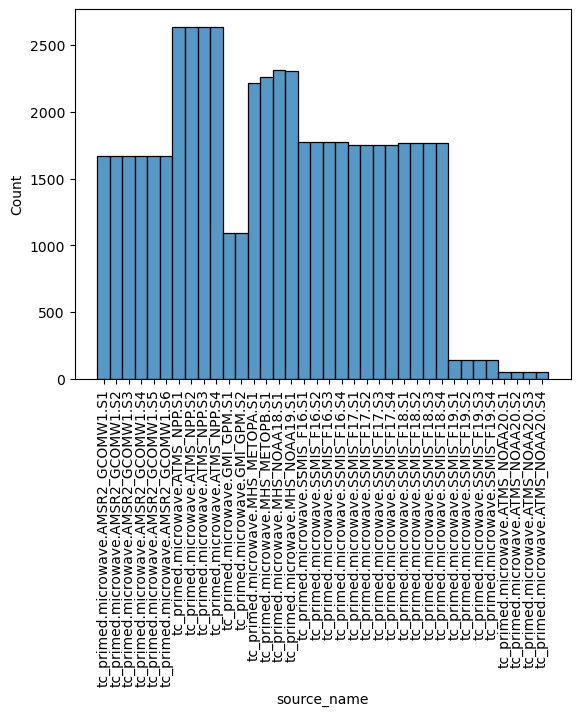

In [6]:
sns.histplot(df, x='source_name')
plt.xticks(rotation=90)
plt.show()

Clearly the amount of available overpasses heavily varies with the source. The main reason is that the number of unique frequencies scanned is inequal between the sensors.  
It might also be partly explained by the times some satellites were sent into orbit, or had their missions ended. Besides, the satellites don't have the same orbits and some of them might more frequently orbit over cyclone-prone areas.

## Repartition by satellite over time

In [7]:
# Compute the number of overpasses per month for each source
month = df.time.dt.to_period('M')
sat = df.source_name.apply(lambda s: s.split('.')[-2].split('_')[0])
monthly_obs = df.groupby([sat, month])['SID'].count().rename('Monthly overpasses').reset_index()
monthly_obs['time'] = monthly_obs.time.dt.to_timestamp()

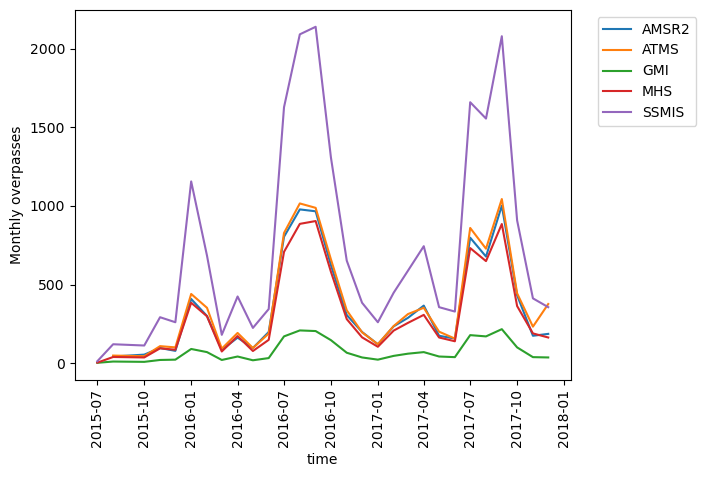

In [8]:
sns.lineplot(monthly_obs, x='time', y='Monthly overpasses', hue='source_name')
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

Let's also look at the counts per sensor and satellite:

In [9]:
sensat = df.source_name.apply(lambda s: s.split('.')[-2])
monthly_obs = df.groupby([sensat, month])['SID'].count().rename('Monthly overpasses').reset_index()
monthly_obs['time'] = monthly_obs.time.dt.to_timestamp()

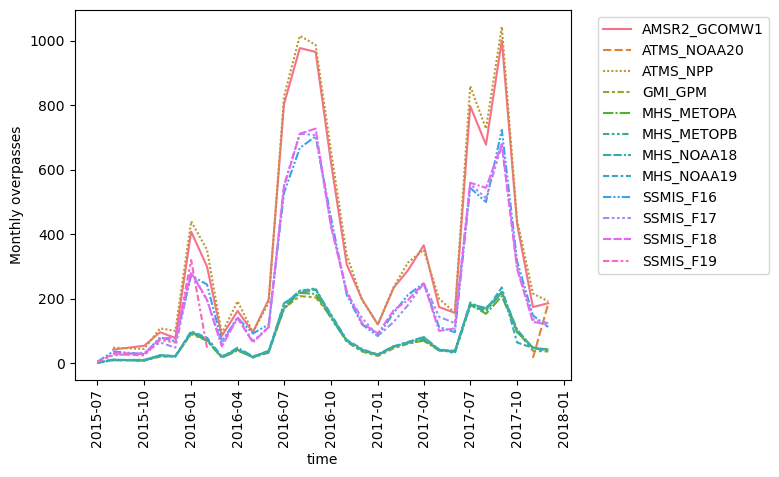

In [10]:
sns.lineplot(monthly_obs, x='time', y='Monthly overpasses', hue='source_name', style='source_name')
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

The observations from the satellite/sensor pair ```SSMIS_F19``` abruptly end in early 2016, while ```ATMS_NOAA20``` only started returning observations in late 2017.

## Number of observations over short time periods
Given a ```SID```, a synoptic time $t_0$ (0000Z, 0600Z, 1200Z, 1800Z), and a time delta $\Delta t$, we'd like to know how many observations are available during the period $t_0 - \Delta t$.  
The synoptic times are the ones which best tracks and ERA5 data are available.

In [11]:
dt = pd.Timedelta(24, 'h')

In [12]:
# Compute the synoptic time that is before and closest to the observation time
df["syn_time"] = df.time.dt.ceil(freq='6h')
# Compute the synoptic times up to which the observations are available
df["syn_time"] = df.apply(lambda row: pd.date_range(row['syn_time'], row['time'] + dt, freq='6h'), axis=1)
df = df.explode('syn_time')
df.head()

,SID,time,season,basin,cyclone_number,source,source_name,syn_time
0,2016AL1,2016-01-07 06:41:07,2016,AL,1,0,tc_primed.microwave.AMSR2_GCOMW1.S1,2016-01-07 12:00:00
0,2016AL1,2016-01-07 06:41:07,2016,AL,1,0,tc_primed.microwave.AMSR2_GCOMW1.S1,2016-01-07 18:00:00
0,2016AL1,2016-01-07 06:41:07,2016,AL,1,0,tc_primed.microwave.AMSR2_GCOMW1.S1,2016-01-08 00:00:00
0,2016AL1,2016-01-07 06:41:07,2016,AL,1,0,tc_primed.microwave.AMSR2_GCOMW1.S1,2016-01-08 06:00:00
1,2016AL1,2016-01-07 17:40:07,2016,AL,1,0,tc_primed.microwave.AMSR2_GCOMW1.S1,2016-01-07 18:00:00


Let's count how many observations are available at each timestep:

In [13]:
# Compute for each synoptic time that has at least one observation, the number of observations available for each source
available_source_counts = df.explode('syn_time').groupby(['SID', 'syn_time', 'source_name'])['SID'].count().rename('Obs count').reset_index()
available_source_counts.head()

,SID,syn_time,source_name,Obs count
0,2016AL1,2016-01-07,tc_primed.microwave.MHS_NOAA18.S1,1
1,2016AL1,2016-01-07,tc_primed.microwave.SSMIS_F19.S1,1
2,2016AL1,2016-01-07,tc_primed.microwave.SSMIS_F19.S2,1
3,2016AL1,2016-01-07,tc_primed.microwave.SSMIS_F19.S3,1
4,2016AL1,2016-01-07,tc_primed.microwave.SSMIS_F19.S4,1


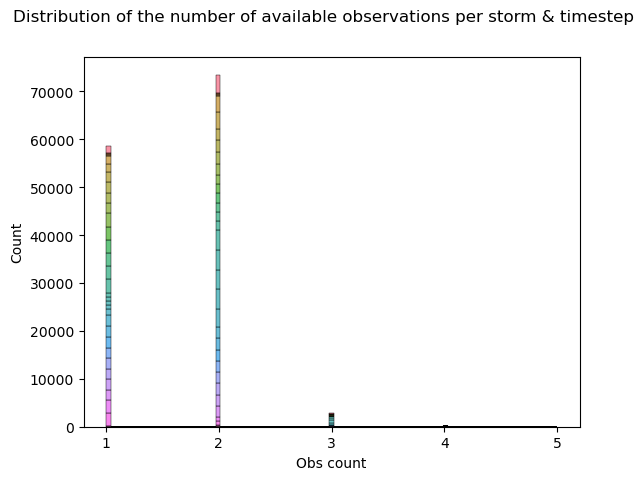

In [14]:
sns.histplot(available_source_counts, x='Obs count', hue='source_name', legend=False, multiple='stack')
plt.xticks(available_source_counts['Obs count'].drop_duplicates().sort_values())
plt.suptitle('Distribution of the number of available observations per storm & timestep')
plt.show()

We obtain multiples of 4 as an observation that is available at time $t_0$ is also available at $t_0+6h,+12h,+18h$ if $\Delta t=24h$. This means that for the vast majority of storm/time/source combinations, 1 or 2 observations are available.  
Still, the question is which timesteps should be avoided because they contain too many missing sources. To answer this, we need to compute the number of available sources per timestep and look at its distribution:

In [15]:
# Compute the number of available sources per timestep
availability = df.groupby(['SID', 'syn_time'])['source_name'].nunique().rename('Available sources').reset_index()
# Compute the proportion of available sources per timestep
availability['Proportion of available sources'] = availability['Available sources'] / dataset.get_n_sources()
availability.head()

,SID,syn_time,Available sources,Proportion of available sources
0,2016AL1,2016-01-07 00:00:00,5,0.138889
1,2016AL1,2016-01-07 06:00:00,11,0.305556
2,2016AL1,2016-01-07 12:00:00,26,0.722222
3,2016AL1,2016-01-07 18:00:00,26,0.722222
4,2016AL1,2016-01-08 00:00:00,30,0.833333


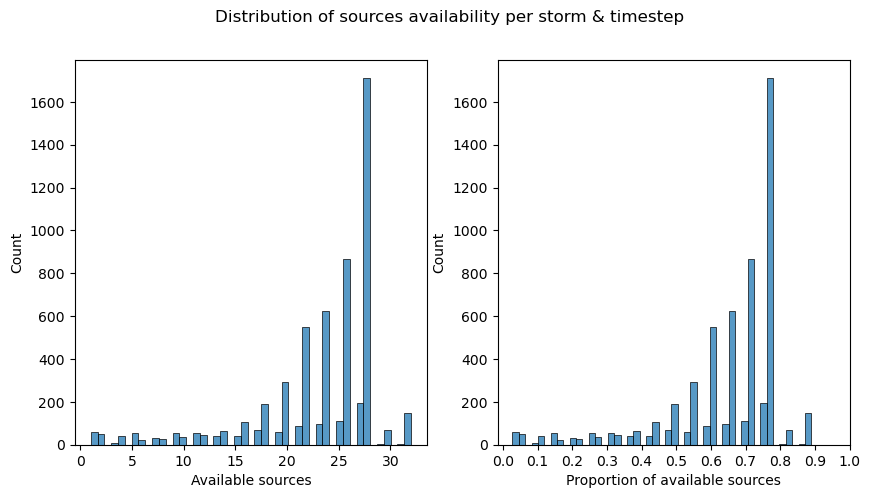

In [16]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
sns.histplot(availability, x='Available sources')
plt.subplot(122)
sns.histplot(availability, x='Proportion of available sources')
plt.xticks(np.linspace(0, 1, 11))
plt.suptitle('Distribution of sources availability per storm & timestep')
plt.show()

The vast majority of timesteps have between 70 and 90% of sources available (i.e. at least one observation is available between $t_0$ and $t_0 - \Delta t$). Of course, this is heavily dependent on $\Delta t$.  
We can expect that the more sources are available at a given $t_0$, the easier the ML task is. Thus we want to discard timesteps for which the proportion of available sources is too low; however this will naturally decrease the amount of samples in the final dataset. In order to make a decision on the minimum proportion of available sources a timestep must have to be included, we need to look at how the resulting data size decreases:

In [17]:
def n_samples_at_min_availability(avail_df, min_availibility):
    """Computes the number of timesteps whose proportion of available sources is at least min_availability"""
    return (avail_df['Proportion of available sources'] >= min_availibility).sum()

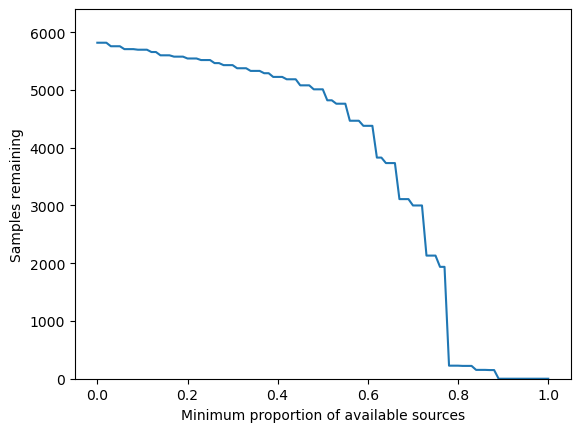

In [18]:
thresholds = np.linspace(0, 1, 101)
n_samples = [n_samples_at_min_availability(availability, thresh) for thresh in thresholds]
plt.plot(thresholds, n_samples)
plt.xlabel('Minimum proportion of available sources')
plt.ylabel('Samples remaining')
plt.ylim(0, max(n_samples) * 1.1)
plt.show()

The number of samples plummets around 60% of sources available and becomes essentially none after 80%.